In [7]:
import json
import skimage.transform
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Load training annotations

points1 = json.load(open('./whale-2015/points1.json'))
points2 = json.load(open('./whale-2015/points2.json'))

p1s = np.array([(p['annotations'][0]['x'], p['annotations'][0]['y']) for p in points1])
p2s = np.array([(p['annotations'][0]['x'], p['annotations'][0]['y']) for p in points2])
fns = np.array([p['filename'] for p in points1])

In [13]:
# training images resized to 640x640 (preserving aspect ratio, black background, centered vertically)
DATA_DIR = './data/train640'

# original training images
ORIG_DATA_DIR = './data/train'

In [14]:
# convert training annotations to resized image coordinates

p1ts = []
p2ts = []
for i in range(len(p1s)):
    fn = fns[i]
    im = plt.imread('{}/{}'.format(DATA_DIR, fn))
    im0 = plt.imread('{}/{}'.format(ORIG_DATA_DIR, fn))
    if im0.shape[0] > im0.shape[1]:
        raise RuntimeError
    x1, y1 = p1s[i]
    x1 = x1 * 640./im0.shape[1]
    y1 = y1 * 640./im0.shape[1] + (640 - im0.shape[0]*640./im0.shape[1]) / 2    
    p1ts.append((x1, y1))
    
    x1, y1 = p2s[i]
    x1 = x1 * 640./im0.shape[1]
    y1 = y1 * 640./im0.shape[1] + (640 - im0.shape[0]*640./im0.shape[1]) / 2    
    p2ts.append((x1, y1))
    
p1ts = np.array(p1ts)
p2ts = np.array(p2ts)

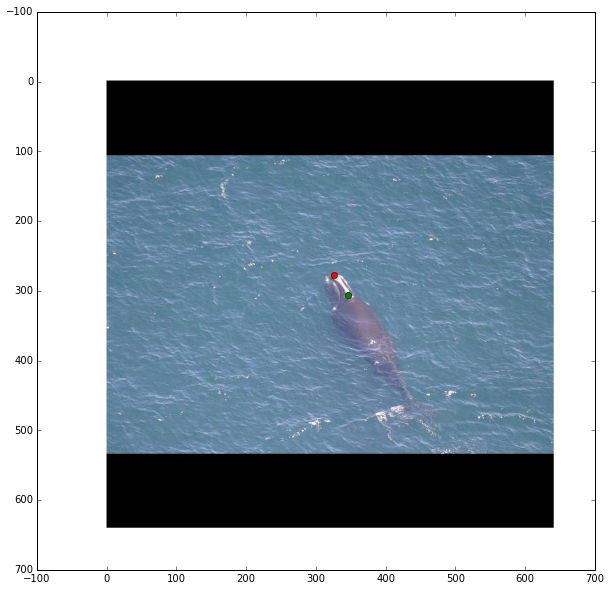

In [15]:
# Plot an image to verify
fn = fns[20]
im = plt.imread('{}/{}'.format(DATA_DIR, fn))
im0 = plt.imread('{}/{}'.format(ORIG_DATA_DIR, fn))

plt.figure(figsize=(10,10))
plt.imshow(im)

x1, y1 = p1ts[20]
plt.plot([x1,], [y1,], 'ro')

x1, y1 = p2ts[20]
plt.plot([x1,], [y1,], 'go')


In [ ]:
#import pickle
#pickle.dump({'filenames':fns, 'point1':p1ts, 'point2':p2ts}, open('train640data.pkl', 'w'))

In [4]:
#d = pickle.load(open('train640data.pkl'))
#fns = d['filenames']
#p1ts = d['point1']
#p2ts = d['point2']

In [29]:
# generate batch of images and blowhole masks

def batch(N):
    X = np.zeros((N, 3, 320, 320)).astype('float32')
    Mask = np.zeros((N, 1, 320, 320)).astype('float32')
    
    idx = np.random.randint(0, len(fns), N)
    for n, i in enumerate(idx):
        fn = fns[i]

        im = plt.imread('./data/train640/{}'.format(fn))
        im = im[::2, ::2]
        im = im/255. - 0.5
        mask = np.zeros(im.shape[:2])

        x1, y1 = p1ts[i]
        x1 = int(x1 // 2)
        y1 = int(y1 // 2)
        try:
            mask[y1, x1] = 1
        except IndexError:
            pass

        Mask[n] = mask
        X[n] = im.transpose(2, 0, 1)
    return X, Mask

In [23]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer

from lasagne.nonlinearities import softmax

In [24]:
# Based on Recombinator Network from http://arxiv.org/abs/1511.07356

def build_net(IMAGE_W):
    net = {}
    l = InputLayer((None, 3, IMAGE_W, IMAGE_W))
    net['input'] = l

    l = Conv(l, 16, 3, pad='same')
    net['T4'] = l

    l = Conv(Pool(l, 2), 32, 3, pad='same')
    net['T3'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T2'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T1'] = l

    l = Conv(Conv(net['T1'], 48, 3, pad='same'), 48, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = Conv(Conv(l, 48, 3, pad='same'), 32, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = Conv(Conv(l, 32, 3, pad='same'), 16, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = Conv(Conv(l, 16, 3, pad='same'), 1, 3, pad='same', nonlinearity=None)
    
    l = lasagne.layers.ReshapeLayer(l, ([0], -1))
    l = lasagne.layers.NonlinearityLayer(l, softmax)
    l = lasagne.layers.ReshapeLayer(l, ([0], 1, IMAGE_W, IMAGE_W))
    net['M4'] = l

    return net

In [25]:
IMAGE_W = 320
net = build_net(IMAGE_W)
pv0 = lasagne.layers.get_all_param_values(net['M4'])

In [30]:
X = T.tensor4()
Y = T.tensor4()
output = lasagne.layers.get_output(net['M4'], X)

loss = lasagne.objectives.binary_crossentropy(output.reshape((-1, IMAGE_W*IMAGE_W)),
                                              Y.reshape((-1, IMAGE_W*IMAGE_W))
                                             )
loss = T.mean(loss)

params = lasagne.layers.get_all_params(net['M4'])

LR = theano.shared(np.array(0.0001).astype('float32'))
updates = lasagne.updates.adam(loss, params, learning_rate=LR)

In [31]:
#lasagne.layers.set_all_param_values(net['M4'], pv0)

In [32]:
f_predict = theano.function([X], output)
f_train = theano.function([X, Y], loss, updates=updates)

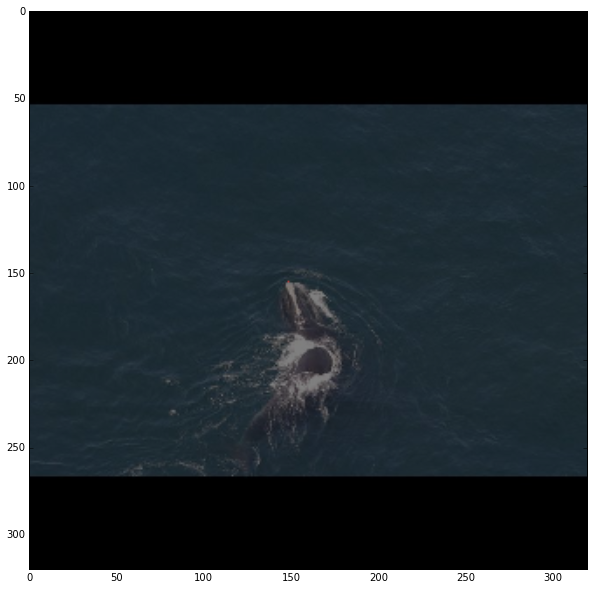

In [63]:
# check batch generation (look for single red pixel!)
Xb, Mb = batch(16)
plt.figure(figsize=(10, 10))
plt.imshow(0.5*(Xb[0].transpose(1,2,0)+0.5) +  Mb[0,0][:,:,np.newaxis]*[1,0,0] * 0.5)

In [213]:
# don't know yet if this is too much or too little training... 
# loss barely changes, need better metric
for _ in range(1000):
    Xb, Mb = batch(32)
    print f_train(Xb, Mb)

6.87285428285e-05
7.31905311113e-05
6.5984298999e-05
6.48682835163e-05
6.77629941492e-05
6.57663622405e-05
6.89371008775e-05
6.95958806318e-05
6.35967880953e-05
6.4955012931e-05
6.85460545355e-05
6.90460583428e-05
6.66369742248e-05
7.01439930708e-05
6.29756686976e-05
6.42300801701e-05
6.86206112732e-05
6.22763691354e-05
6.76457057125e-05
7.09397063474e-05
6.37679186184e-05
6.44653118798e-05
6.37618431938e-05
6.94255722919e-05
6.47931228741e-05
7.0296053309e-05
6.70053632348e-05
6.25665561529e-05
6.0901267716e-05
7.07536746631e-05
7.91594575276e-05
7.05335332896e-05
5.97320940869e-05
6.59963552607e-05
6.66584601277e-05
6.70944937156e-05
7.0815149229e-05
6.43046150799e-05
6.87344072503e-05
6.00105740887e-05
6.9239315053e-05
6.76618146827e-05
6.22268489678e-05
6.54316972941e-05
6.72878377372e-05
5.95524325036e-05
6.15732642473e-05
6.80657249177e-05
5.9506688558e-05
7.07597573637e-05
5.79820480198e-05
7.38250964787e-05
6.51054433547e-05
6.62969468976e-05
7.33012857381e-05
6.29374844721e-05

In [ ]:
import pickle

#pvt = lasagne.layers.get_all_param_values(net['M4'])
#pickle.dump(pvt, open('loc_trained_1000epoch.pkl', 'w'))

pvt = pickle.load(open('loc_trained_1000epoch.pkl'))
lasagne.layers.set_all_param_values(net['M4'], pvt)

In [71]:
# try predicting on test image
im = plt.imread('./data/test/w_10003.jpg')

im = skimage.transform.resize(im, (im.shape[0]*640/im.shape[1], 640))
a = (640 - im.shape[0])//2
im = np.pad(im, [(a, a), (0, 0), (0, 0)], mode='constant')
im = im[::2, ::2].transpose(2, 0, 1)[np.newaxis] - 0.5

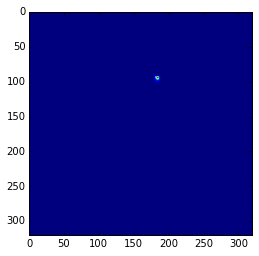

In [73]:
p = f_predict(im.astype('float32'))
p /= p.max()
plt.imshow(p[0,0])

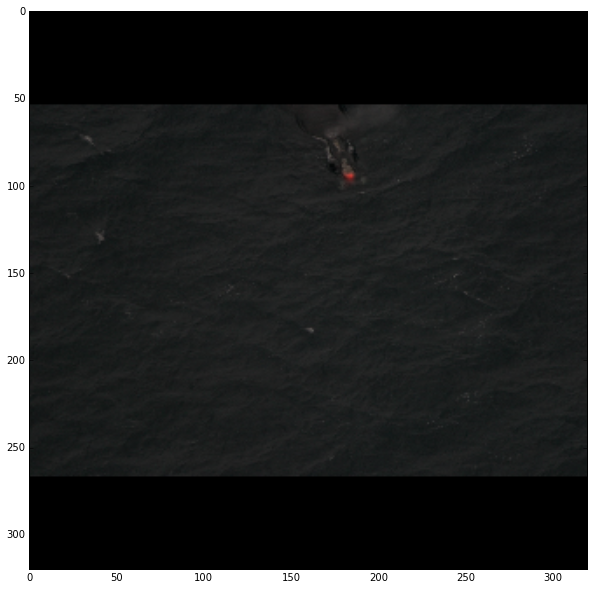

In [74]:
# it works!

plt.figure(figsize=(10, 10))
a = 0.5*(im[0].transpose(1,2,0)+0.5) +  0.5*p[0,0][:,:,np.newaxis]*[1,0,0]
plt.imshow(a)